<a href="https://colab.research.google.com/github/aneesh-kaitou1412/vae-mnist/blob/master/Convolutional_VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Variational Autoencoder for MNIST



## Preparation

* Mounting to Google Drive to save Model Parameters for later 

In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Imports

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Loading MNIST Dataset

In [61]:
(x_train, y_train), (x_test, _) = keras.datasets.mnist.load_data()

def preprocess_images(images):
  return np.expand_dims(images, -1).astype("float32") / 255
  ## Optionally can write code to make it Binary (0/1) [won't work for noisy data]

x_train = preprocess_images(x_train)
x_test = preprocess_images(x_test)

train_size = x_train.shape[0]
batch_size = 128
test_size = x_test.shape[0]

x_train_dataset = (tf.data.Dataset.from_tensor_slices(x_train)
                 .shuffle(train_size).batch(batch_size))
x_test_dataset = (tf.data.Dataset.from_tensor_slices(x_test)
                .shuffle(test_size).batch(batch_size))

## Dimension of z vector (over which the Probability Distribution is learnt)
latent_dim = 2

input_shape = x_train.shape[1:]
batch_input_shape = (batch_size, x_train.shape[1], x_train.shape[2], x_train.shape[3],)

## Model Architecture

Three important components are involved in a VAE architecture
* Encoder
* Sampling Layer for Latent Space 
* Decoder

In [15]:
""" Gaussian Latent Space Sampling Layer """
class GaussianLatentSpaceSampler(layers.Layer):
  """ Uses (z_mean, z_log_var) to sample z, a vector encoding the digit """

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [16]:
""" Encoder Model Function, returns the Encoder Model Object """
def GaussianEncoder(input_shape, latent_dim):
  encoder_inputs = keras.Input(shape=input_shape)
  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", strides=2, padding="same")(encoder_inputs)
  x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", strides=2, padding="same")(x)
  x = layers.Flatten(name="dense_flatten")(x)
  x = layers.Dense(units=16, activation="relu")(x)
  z_mean = layers.Dense(units=latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(units=latent_dim, name="z_log_var")(x)
  encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")
  return encoder

encoder = GaussianEncoder(input_shape, latent_dim)
encoder.summary()
reconstruction_conv_shape = encoder.get_layer("dense_flatten").input_shape[1:]

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
dense_flatten (Flatten)         (None, 3136)         0           conv2d_3[0][0]                   
____________________________________________________________________________________________

In [17]:
""" Decoder Model Function, returns the Decoder Model Object 
    We construct the Decoder with a Reverse Architecture as that of the Encoder    
"""
def Decoder(latent_dim):
  latent_inputs = keras.Input(shape=(latent_dim,))
  x = layers.Dense(np.prod(reconstruction_conv_shape), activation="relu")(latent_inputs)
  x = layers.Reshape(reconstruction_conv_shape)(x)
  x = layers.Conv2DTranspose(filters=64, kernel_size=3, activation="relu", strides=2, padding="same")(x)
  x = layers.Conv2DTranspose(filters=32, kernel_size=3, activation="relu", strides=2, padding="same")(x)

  decoder_outputs = layers.Conv2DTranspose(filters=1, kernel_size=3, activation="sigmoid", padding="same")(x)
  decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
  return decoder

decoder = Decoder(latent_dim)
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

## Constructing the Variational Autoencoder Class

In [18]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.sampler = GaussianLatentSpaceSampler()

  def train_step(self, data):
    with tf.GradientTape() as tape:
      # Encode the Data, to find Mean and Variance
      z_mean, z_log_var = self.encoder(data)

      # Sample from Latent Distribution
      z = self.sampler((z_mean, z_log_var))

      # Reconstruct from the Sampled Point
      reconstruction = self.decoder(z)

      # Calculate Reconstruction Loss
      reconstruction_loss = tf.reduce_mean(
          keras.losses.binary_crossentropy(data, reconstruction)
      )
      reconstruction_loss *= np.prod(input_shape)

      # Calculate KL Divergence Loss
      kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
      kl_loss = tf.reduce_mean(kl_loss)
      kl_loss *= -0.5


      total_loss = reconstruction_loss + kl_loss
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    
    return {
      "loss": total_loss,
      "reconstruction_loss": reconstruction_loss,
      "kl_loss": kl_loss,
    }

In [19]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train_dataset, epochs=30, batch_size=batch_size)

Epoch 1/30
469/469 [==============================] - 86s 184ms/step - loss: 205.1628 - reconstruction_loss: 201.7275 - kl_loss: 3.4353
Epoch 2/30
469/469 [==============================] - 90s 193ms/step - loss: 168.3761 - reconstruction_loss: 164.6174 - kl_loss: 3.7587
Epoch 3/30
469/469 [==============================] - 90s 191ms/step - loss: 161.6950 - reconstruction_loss: 157.7712 - kl_loss: 3.9238
Epoch 4/30
469/469 [==============================] - 90s 191ms/step - loss: 158.4152 - reconstruction_loss: 154.3765 - kl_loss: 4.0387
Epoch 5/30
469/469 [==============================] - 91s 193ms/step - loss: 156.6685 - reconstruction_loss: 152.6033 - kl_loss: 4.0652
Epoch 6/30
469/469 [==============================] - 90s 192ms/step - loss: 155.3084 - reconstruction_loss: 151.1839 - kl_loss: 4.1245
Epoch 7/30
469/469 [==============================] - 90s 192ms/step - loss: 154.2507 - reconstruction_loss: 150.1215 - kl_loss: 4.1292
Epoch 8/30
469/469 [============================

## Testing the Autoencoder

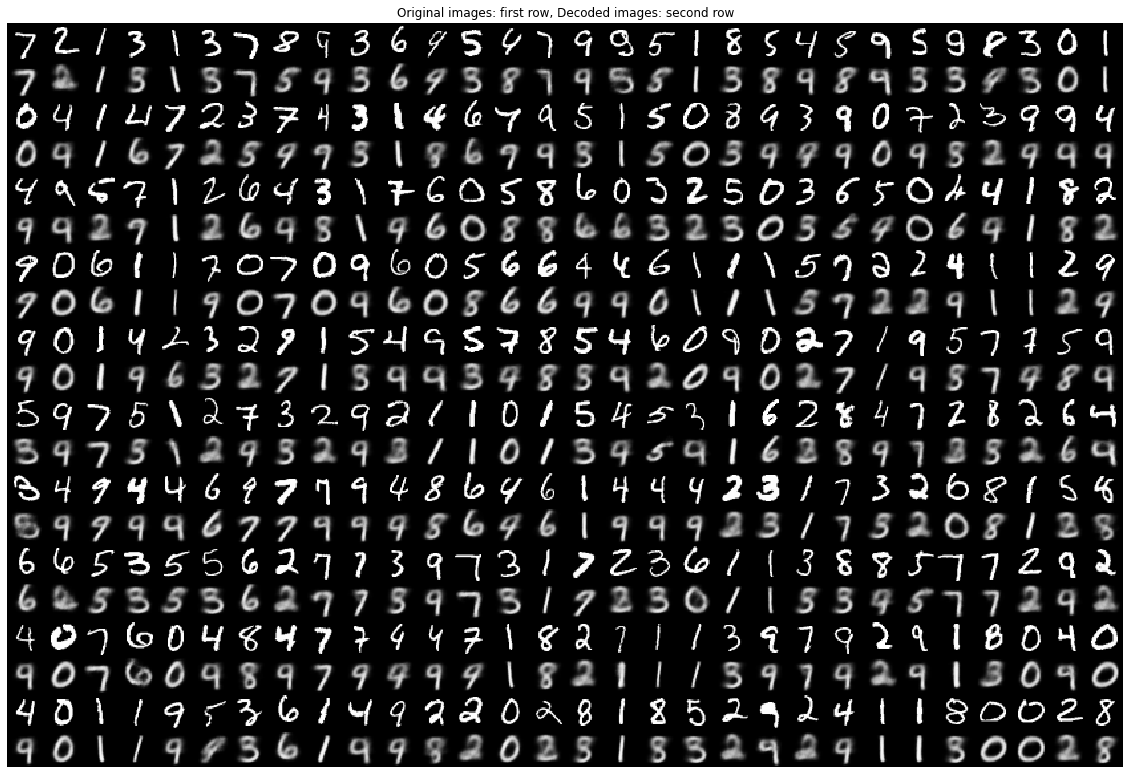

In [57]:
import matplotlib.pyplot as plt

# Predict the Autoencoder output from test images
x_decoded = vae.decoder(vae.sampler(vae.encoder(x_test)))

# Display the 1st 8 original and decoded images
rows, cols = 10, 30
num = rows * cols
imgs = np.concatenate([x_test[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 2, cols, input_shape[0], input_shape[1]))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 2, -1, input_shape[0], input_shape[1]))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.title('Original images: first row, '
          'Decoded images: second row')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()

## Display a Manifold of Digits


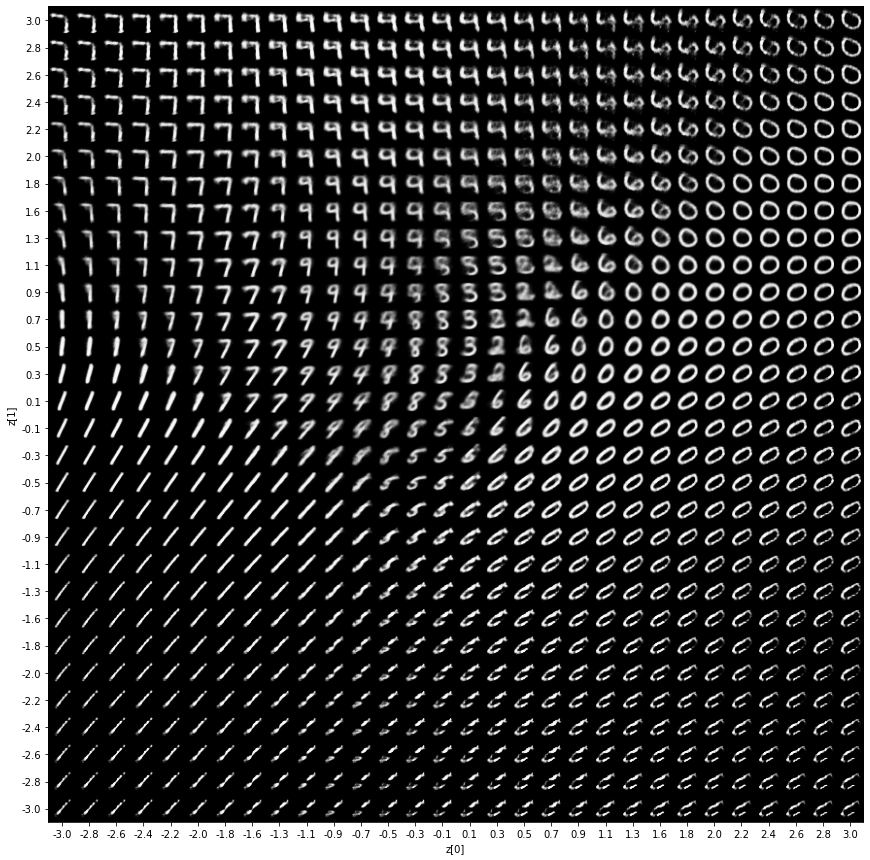

In [60]:
def plot_latent(decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 3.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent(vae.decoder)

## Clustering formed in the Latent Space

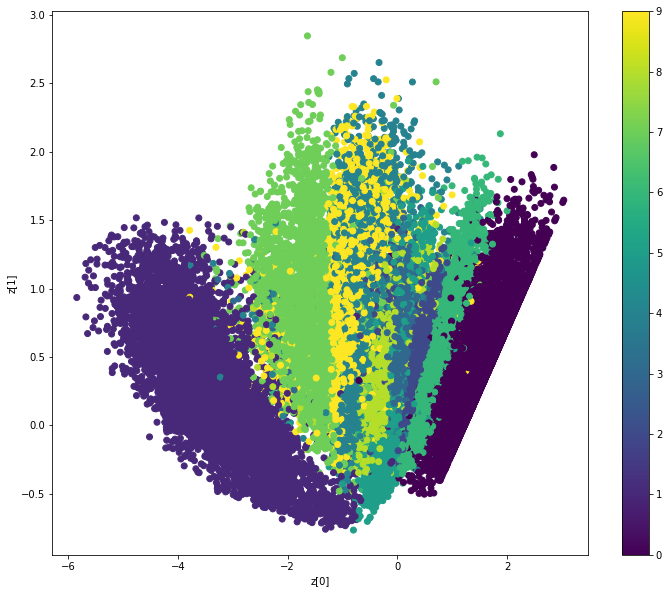

In [63]:
def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, = encoder(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


plot_label_clusters(encoder, x_train, y_train)